### Overfitting and RMSE
Although a low RMSE is generally desirable, an RMSE of 0 on the training data indicates overfitting. The overfitted model will predict the observations just as they appeared in training. This leads to poor generalization and when the RMSE is calculated over the test data it will be relatively much higher than when calculated over the training data.

### Assessing a Model's Generalization Power
Since we choose the best model based on based on the test error we need to fine tune the model’s parameters to give the best generalization power. However, we cannot use the error on the test set to pick the parameters for our model or else we will be overfitting the test set. Thus we need another method to assess generalization power.

### The Train / Validation / Test Approach
Instead of using the test set to asses generalization power we can split the data into three sets: training, validation, and test.

First we train the model on the training set, then we see how it generalizes on to the validation set. We can then adjust the parameters to find those that perform best on the validation set. This way we can get an idea of a models generalization power and fine tune its parameters without overfitting or even looking at the test set. Once we find the best parameters for the validation set we use these parameters to train the model for comparison on the test set.

The test set can then be used to compare only the different models such as the decision tree regressor against a linear regressor, rather than having it compare the same model but with different parameters. This way we can choose the model that best generalized to the test set without overfitting it to the test set.

### Shortcomings of the Train / Validation / Test Approach
Since this approach requires us to use a chunk of data for the validation set we have less data to train the model on. And most models perform worse when given less data to train with. Therefore even by finding the parameters for our model that has the best generalization power we do not as well as we could since we are missing data that could have been used in training.

We also may not even find the best parameters for the model since error varies based on what data is present in the training set and validation set. Thus sometimes the validation set will overestimate or underestimate what the test error will be instead of finding the mean likely error.

### K-fold Cross Validation
Cross-validation is technique for assessing how the results of a statistical analysis will generalize to an independent data set. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

The idea is to hold out part of the available data as a test set. First the training set is split into K parts. K-1 parts are used as training data and 1 part is used for testing. This is repeated K-times, so every part is used as test data, and the average of the accuracies is the cross-validation score. Once we find the best model params, we then use them to train on the full training set. K = 10 is common. 

Scikit-learn's model_selection module has implemented cross validation.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
crime = pd.read_csv(url, header=None, na_values=['?'])
# remove categorical features
crime.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
# remove rows with any missing values
crime.dropna(inplace=True)
# check the shape
crime.shape
X = crime.drop(127, axis=1)
y = crime[127]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

# Here the cross-validation is used with k=10
scores = cross_val_score(tree_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=10, )

tree_reg_rmse = np.sqrt(np.mean(-scores))
tree_reg_rmse

0.26844688838587416

### Scoring the K parts of data
For scoring the k parts of data we used a function called "neg_mean_squared_error". This is simply: 1×𝑀𝑆𝐸

 
The reason for this is that cross_val_score requires similarity function ( as opposed to a distance function).
In MSE, the lower the score the better
In cross_val_score scoring scheme, the greater the score, the better the model
See link below for available scoring functions for regression: http://scikit-learn.org/stable/modules/model_evaluation.html

### Random Forest Regressor
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default) in scikit-learn.

Random Forests works by training many Decision Tree Regressors on random subsets of the features, averaging out the predictions. In general, the class of models wich work by averaging outcomes of a set of other models is called ensemble methods * Subsert of of ensembl machine learning

In [6]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=50, max_depth=3, max_features=10)

### Random Forest Parameters
The number of n_estimators in the RandomForestRegressor defines the number of trees in the ensemble (forest). It is an integer and optional but the default value is 10.

max_features is the maximum number of features to consider when looking for the best split. It can be an int, float, string or None. It is optional and the default value is n_features, which is the number of features when fit is performed.

max_depth is the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Can be int or None, and default is None.

The RandomForest Model yields a slightly lower error value than both the DecisionTreeRegressor and the LinearRegression models

In [7]:
scores = cross_val_score(forest_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=10)
forest_reg_rmse = np.sqrt(-scores)
forest_reg_rmse

array([0.1827964 , 0.14709633, 0.20862979, 0.16403483, 0.16183092,
       0.18703124, 0.1715906 , 0.17778416, 0.1862479 , 0.17744831])

In [8]:
print ("score are %s\n" % forest_reg_rmse)
print ("mean score is %s"  % np.mean(forest_reg_rmse))

score are [0.1827964  0.14709633 0.20862979 0.16403483 0.16183092 0.18703124
 0.1715906  0.17778416 0.1862479  0.17744831]

mean score is 0.17644904639626924


### Using Grid Search For Finding Params That Minimize Loss
Grid search is an exhaustive search over specified parameter values for an estimator. Scikit-Learn offers GridSearchCV (Grid Search Cross-Validation). It takes a list of parameters and some values and exhaustively tries the values using cross-validation. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid. The parameters selected are those that maximize the score of the left out data, unless an explicit score is passed in which case it is used instead.

In [9]:
from sklearn.model_selection import GridSearchCV

grid_search_params = [{'n_estimators':[3, 9, 27, 50, 81], 'max_features': [2, 3, 4, 5, 7, 9, 11]}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, 
                           param_grid=grid_search_params, 
                           cv=10, 
                           scoring = 'neg_mean_squared_error'
                          )

Note that with many parameters and a high K/cv the time to execute the grid search could be very long if you have a large training set. The above search cases represent 35 different combination for n_estimators and max_features
Each of the tests is carried out using cros-validation with k=10.

In [10]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 9, 27, 50, 81], 'max_features': [2, 3, 4, 5, 7, 9, 11]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Grid search has many attributes. Bewlo best_params_ is shown. It returns the parameter setting that gave the best results on the hold out data.

The best estimators was generated from max_features = 3 and n_estimators = 27 is seen in cell below

In [14]:
grid_search.best_params_

{'max_features': 11, 'n_estimators': 81}

best_score_ returns the mean cross-validated score of the best_estimator as shown in the cell below

In [15]:
cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    params, mean_score =  cv_scores['params'][i], cv_scores['mean_test_score'][i]
    print(params, np.sqrt(-mean_score))

{'max_features': 2, 'n_estimators': 3} 0.22413893297199872
{'max_features': 2, 'n_estimators': 9} 0.19330526362329165
{'max_features': 2, 'n_estimators': 27} 0.17846758122631534
{'max_features': 2, 'n_estimators': 50} 0.1777225123071164
{'max_features': 2, 'n_estimators': 81} 0.17913012080135304
{'max_features': 3, 'n_estimators': 3} 0.21827607391659867
{'max_features': 3, 'n_estimators': 9} 0.1873799906933427
{'max_features': 3, 'n_estimators': 27} 0.17505003847522432
{'max_features': 3, 'n_estimators': 50} 0.1751857491195008
{'max_features': 3, 'n_estimators': 81} 0.17506400115212334
{'max_features': 4, 'n_estimators': 3} 0.21632587725394417
{'max_features': 4, 'n_estimators': 9} 0.17668080315595366
{'max_features': 4, 'n_estimators': 27} 0.17863703351308077
{'max_features': 4, 'n_estimators': 50} 0.17315107825128204
{'max_features': 4, 'n_estimators': 81} 0.17146805701830553
{'max_features': 5, 'n_estimators': 3} 0.19857640719193945
{'max_features': 5, 'n_estimators': 9} 0.185408887

best_estimator_ returns the estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data

In [16]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=11, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=81, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [17]:
# Let's predict the new values using this best estimator found uisng the grid search

training_set_predictions_rand_forest = grid_search.best_estimator_.predict(X_train)

Text(0, 0.5, 'Measured  a1')

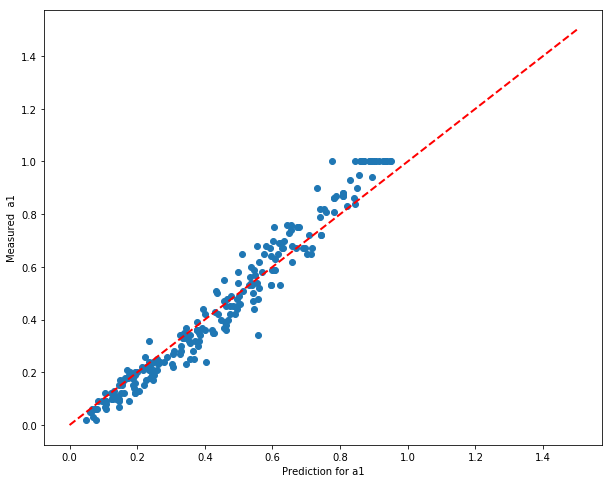

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,8))

plt.scatter(training_set_predictions_rand_forest, y_train.values)
plt.plot(
    [0,1.5],
    [0,1.5],
    color='r', linewidth =2, linestyle = '--')

plt.xlabel("Prediction for a1")
plt.ylabel("Measured  a1")

### Testing
Once we have tweaked all the parameters for all models, we can use the test data to compare the models' generalization performance. The approach is the same as that followed above:
For each of model, we run the prediction on test data and compare the predicted with the observed values
We select the model that makes the smallest error
We determine whether the generalized performance is sufficient for our application
The performance requirements for a patient-facing application are perhaps not the same as those for an application for predicting algae blooms
Not that in this approach, we are rewarding models that generalize well even if they are more complex
We don't penalize complex models if they result is high generalization performance
Between models with relatively similar generalization performance, we need to choose the one with fewer parameters